In [32]:
import pandas as pd
import numpy as np
import random
from PIL import Image
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchaudio
import torchaudio.transforms as T

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

* my matplotlib won't spot acting up so I need 2 following sells to make it work

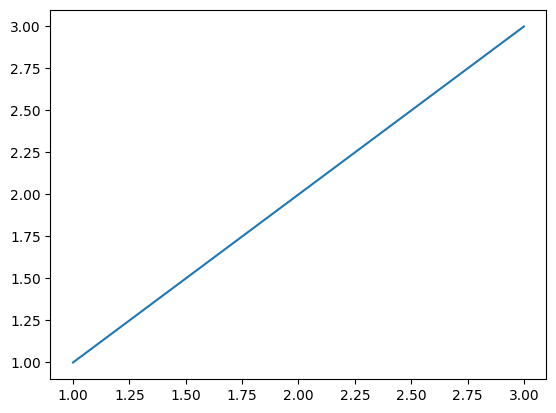

In [2]:
x=[1,2,3]
y=[1,2,3]
plt.plot(x,y)

### Looking at dataframes content and audiofiles characteristics

In [4]:
df_speech = pd.read_csv('./cleanSpeech.csv')
df_speech

,filename
0,./ms-snsd/CleanSpeech_training/clnsp1.wav
1,./ms-snsd/CleanSpeech_training/clnsp2.wav
2,./ms-snsd/CleanSpeech_training/clnsp3.wav
3,./ms-snsd/CleanSpeech_training/clnsp4.wav
4,./ms-snsd/CleanSpeech_training/clnsp5.wav
...,...
57,./ms-snsd/CleanSpeech_training/clnsp58.wav
58,./ms-snsd/CleanSpeech_training/clnsp59.wav
59,./ms-snsd/CleanSpeech_training/clnsp60.wav
60,./ms-snsd/CleanSpeech_training/clnsp61.wav


In [5]:
df_noise = pd.read_csv('./noises.csv')
df_noise

,filename
0,./ms-snsd/Noise_training/noisy1_SNRdb_0.0.wav
1,./ms-snsd/Noise_training/noisy1_SNRdb_10.0.wav
2,./ms-snsd/Noise_training/noisy1_SNRdb_20.0.wav
3,./ms-snsd/Noise_training/noisy1_SNRdb_30.0.wav
4,./ms-snsd/Noise_training/noisy2_SNRdb_0.0.wav
...,...
243,./ms-snsd/Noise_training/noisy61_SNRdb_30.0.wav
244,./ms-snsd/Noise_training/noisy62_SNRdb_0.0.wav
245,./ms-snsd/Noise_training/noisy62_SNRdb_10.0.wav
246,./ms-snsd/Noise_training/noisy62_SNRdb_20.0.wav


In [ ]:
sample_wav_file = df_speech['filename'][1]
waveform, sample_rate = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate}')

Shape of the waveform: torch.Size([1, 254880])

Sampling rate of the audio file: 16000


In [ ]:
# get mel spectrogram
eps_value=1e-6
melsp = torch.log(mel_spectrogram(waveform) + eps_value)
melsp

tensor([[[ -5.4426,  -3.9191,  -3.9538,  ...,  -3.2987,  -4.1951,  -3.7563],
         [ -5.1267,  -4.4480,  -5.7877,  ...,  -3.9969,  -3.6791,  -4.5774],
         [ -4.9983,  -5.0278,  -4.0236,  ...,  -3.4089,  -3.5102,  -4.8489],
         ...,
         [-13.6617, -13.7507, -13.7611,  ..., -10.4662, -13.1461, -13.0078],
         [-13.7061, -13.7851, -13.7581,  ..., -10.3248, -13.2020, -12.9086],
         [-13.7156, -13.7930, -13.7814,  ..., -10.8343, -12.7137, -12.8331]]])

In [ ]:
melsp.size(2)

498

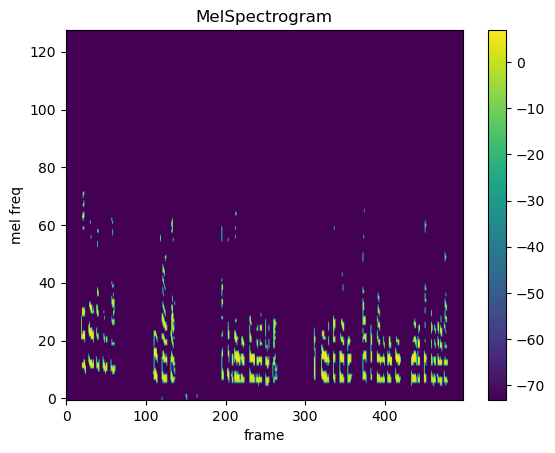

In [ ]:
# plot mel spectrogram
img = plot_spectrogram(melsp[0], title="MelSpectrogram", ylabel='mel freq')
img

In [ ]:
mel_nframes = 300
n_mels = 128
image = torch.full((1, n_mels, mel_nframes), melsp.min())
image

tensor([[[-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155],
         [-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155],
         [-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155],
         ...,
         [-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155],
         [-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155],
         [-13.8155, -13.8155, -13.8155,  ..., -13.8155, -13.8155, -13.8155]]])

In [ ]:
image[0, :, :mel_nframes] = melsp[:, :, :mel_nframes]
image

tensor([[[ -5.4426,  -3.9191,  -3.9538,  ...,  -1.0063,  -0.7715,  -1.3329],
         [ -5.1267,  -4.4480,  -5.7877,  ...,  -1.2958,  -1.4068,  -2.2788],
         [ -4.9983,  -5.0278,  -4.0236,  ...,  -2.1181,  -2.5497,  -3.6409],
         ...,
         [-13.6617, -13.7507, -13.7611,  ..., -13.7297, -13.6602, -13.1673],
         [-13.7061, -13.7851, -13.7581,  ..., -13.7490, -13.6541, -13.0812],
         [-13.7156, -13.7930, -13.7814,  ..., -13.6882, -13.6537, -12.9185]]])

In [ ]:
image.size()

torch.Size([1, 128, 300])

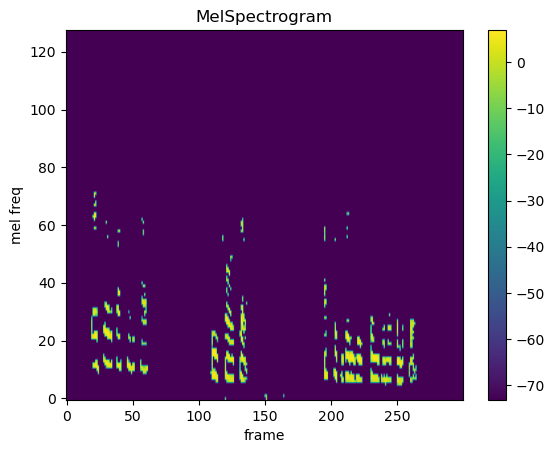

In [ ]:
# get mel spectrogram cropped to the 300 n-frames
im = plot_spectrogram(image[0], title="MelSpectrogram", ylabel='mel freq')
im

In [ ]:
a = image/255
a

tensor([[[-0.0213, -0.0154, -0.0155,  ..., -0.0039, -0.0030, -0.0052],
         [-0.0201, -0.0174, -0.0227,  ..., -0.0051, -0.0055, -0.0089],
         [-0.0196, -0.0197, -0.0158,  ..., -0.0083, -0.0100, -0.0143],
         ...,
         [-0.0536, -0.0539, -0.0540,  ..., -0.0538, -0.0536, -0.0516],
         [-0.0537, -0.0541, -0.0540,  ..., -0.0539, -0.0535, -0.0513],
         [-0.0538, -0.0541, -0.0540,  ..., -0.0537, -0.0535, -0.0507]]])

In [ ]:
sample_wav_file = df_noise['filename'][2]
waveform1, sample_rate1 = torchaudio.load(sample_wav_file)
print(f'Shape of the waveform: {waveform1.size()}\n')
print(f'Sampling rate of the audio file: {sample_rate1}')

Shape of the waveform: torch.Size([1, 163520])

Sampling rate of the audio file: 16000


In [ ]:
melsp1 = torch.log(mel_spectrogram(waveform1)+eps_value)

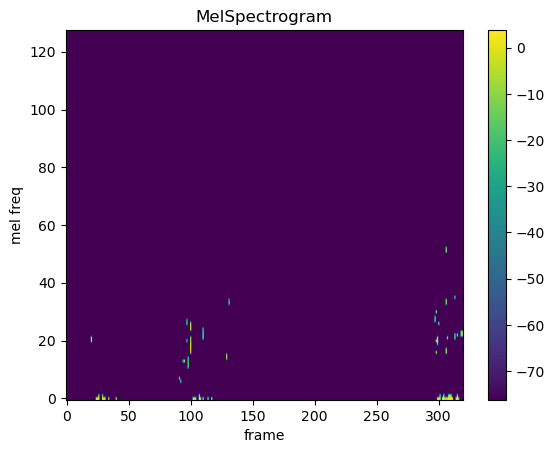

In [ ]:
img1 = plot_spectrogram(melsp1[0], title="MelSpectrogram", ylabel='mel freq')
img1

In [ ]:
image1 = torch.full((1, n_mels, mel_nframes), melsp1.median())
image1

tensor([[[-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805],
         [-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805],
         [-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805],
         ...,
         [-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805],
         [-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805],
         [-10.2805, -10.2805, -10.2805,  ..., -10.2805, -10.2805, -10.2805]]])

In [ ]:
image1[0, :, :mel_nframes] = melsp1[:, :, :mel_nframes]
image1.size()

torch.Size([1, 128, 300])

In [ ]:
# combining clean and noisy audios
mainmel = image+image1
mainmel

tensor([[[-17.2609, -17.0250, -17.0819,  ...,  -2.4128,  -1.1022,  -0.7932],
         [-17.8607, -18.0474, -19.2915,  ...,  -4.3416,  -2.9666,  -3.5022],
         [-16.8382, -17.2448, -16.4780,  ...,  -6.6481,  -5.9690,  -7.0976],
         ...,
         [-27.4750, -27.5636, -27.5760,  ..., -20.0340, -19.5406, -19.6186],
         [-27.5190, -27.5992, -27.5730,  ..., -20.6935, -19.4667, -19.3493],
         [-27.5287, -27.6074, -27.5959,  ..., -20.9109, -19.2852, -19.1552]]])

In [ ]:
mainmel.size()

torch.Size([1, 128, 300])

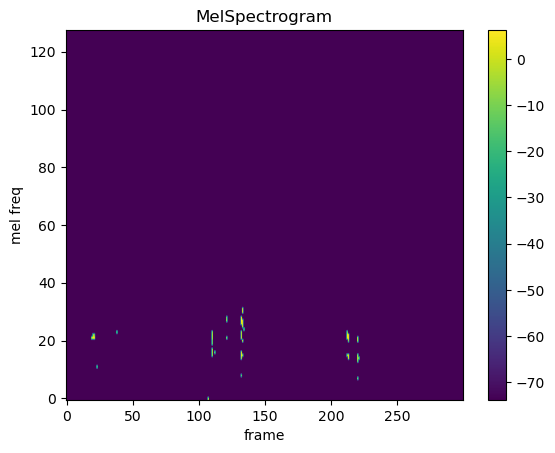

In [ ]:
mainimg = plot_spectrogram(mainmel[0], title="MelSpectrogram", ylabel='mel freq')
mainimg

### Function to make and plot MelSpectrogram

In [ ]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto"):
    fig, axs = plt.subplots(1, 1)

    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")

    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)

    fig.colorbar(im, ax=axs)
    plt.savefig("output.jpg")
    plt.show()

In [ ]:
sample_rate = 16000
n_fft = 1024
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   center=True,
                                   pad_mode="reflect",
                                   power=2.0,
                                   norm='slaney',
                                   n_mels=n_mels,
                                   mel_scale="htk")

### MelSpectrogram of a clean speech

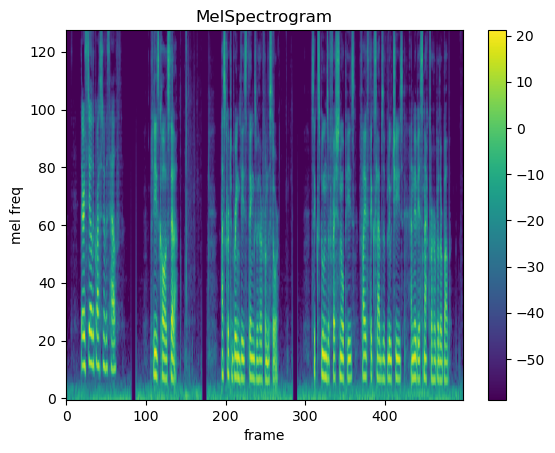

In [ ]:
melspec = mel_spectrogram(waveform)
img = plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')
img

## MelSpec graph w/o unnecessary info

In [ ]:
def plot_mel_spec_clean(spec, aspect="auto"):
    im = plt.imshow(librosa.power_to_db(spec),
                    origin="lower", aspect=aspect)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible (False)

    plt.savefig("output.png", bbox_inches='tight',
                pad_inches=0, transparent=True)

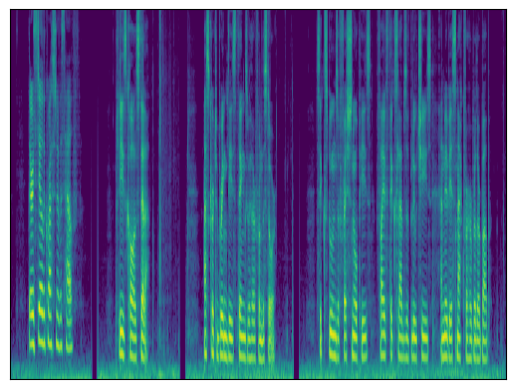

In [ ]:
melspec = mel_spectrogram(waveform)
im = plot_mel_spec_clean(melspec[0])
im

### Checking dimensions placement

In [ ]:
img = Image.open(r'./output.png')
print(np.array(img).shape)

(369, 496, 4)


In [ ]:
def prepare_image(path):
    size = (369, 369)
    img = Image.open(path).convert('RGB').resize(size)

    np_img = np.array(img, dtype='uint8')
    img_tens = np.transpose(np_img, (2, 1, 0))/255
    tens = torch.from_numpy(img_tens)

    return tens

In [ ]:
l = prepare_image(r'./output.png')

In [ ]:
l.shape

torch.Size([3, 369, 369])

### MelSpectrogram of a noisy speech

In [ ]:
b = waveform + waveform1
b.size()

torch.Size([1, 163520])

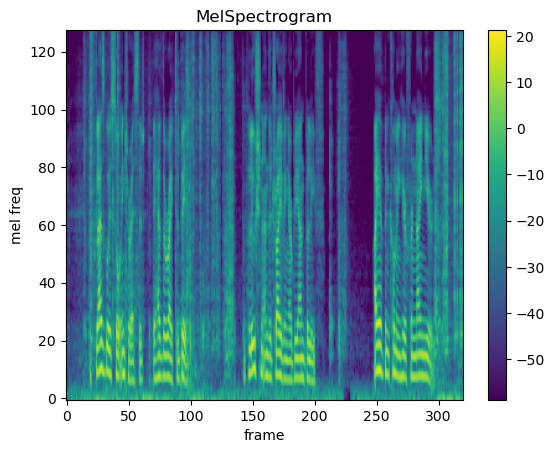

In [ ]:
melspec = mel_spectrogram(b)
plot_spectrogram(melspec[0], title="MelSpectrogram", ylabel='mel freq')

### Custom Dataset

In [127]:
class AudioDataset(Dataset):

    def __init__(self, path_speech, path_noise, eps_value=1e-6,\
                 mel_nframes=300, sample_rate = 16000, n_fft = 1024,\
                 hop_length = 512, n_mels = 128):

        self.speech = pd.read_csv(path_speech)
        self.noise = pd.read_csv(path_noise)
        self.eps_value = eps_value
        self.mel_nframes = mel_nframes
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.mel_spectrogram = T.MelSpectrogram(sample_rate=self.sample_rate,
                                           n_fft=self.n_fft,
                                           hop_length=self.hop_length,
                                           center=True,
                                           pad_mode="reflect",
                                           power=2.0,
                                           norm='slaney',
                                           n_mels=self.n_mels,
                                           mel_scale="htk")


    def __len__(self):

        return len(self.speech)


    def get_same_shape(self, waveform):

        melsp = torch.log(self.mel_spectrogram(waveform) + self.eps_value)
        image_tens = torch.full((3, self.n_mels, self.mel_nframes), melsp.min())
        image_tens[0, :, :self.mel_nframes] = melsp[:, :, :self.mel_nframes]

        return image_tens/255


    def load_item(self, df, idx):

        # idx = random.randint(0, len(df)-1)

        sample_wav_file = df['filename'][idx]
        wave, _ = torchaudio.load(sample_wav_file)

        wave_melsp = self.get_same_shape(wave)

        return wave_melsp


    def __getitem__(self, idx):

        wave_speech = self.load_item(self.speech, idx)

        luck = random.random()
        if luck > 0.5:

            wave_noise = self.load_item(self.noise, idx)

            wave_out = wave_speech + wave_noise
            label = 1

        else:
            wave_out = wave_speech
            label = 0

        return wave_out, torch.tensor([label])

In [128]:
audio_dataset = AudioDataset('./cleanSpeech.csv', './noises.csv')

In [129]:
idx = 0
audio, class_label = audio_dataset[0]

In [130]:
class_label

tensor([1])

In [131]:
audio

tensor([[[-0.0617, -0.0680, -0.0692,  ..., -0.0130, -0.0088, -0.0099],
         [-0.0547, -0.0654, -0.0691,  ..., -0.0232, -0.0175, -0.0130],
         [-0.0514, -0.0583, -0.0602,  ..., -0.0351, -0.0283, -0.0220],
         ...,
         [-0.1078, -0.1076, -0.1068,  ..., -0.0456, -0.0383, -0.0427],
         [-0.1077, -0.1077, -0.1074,  ..., -0.0484, -0.0412, -0.0444],
         [-0.1075, -0.1078, -0.1063,  ..., -0.0522, -0.0404, -0.0459]],

        [[-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         ...,
         [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084]],

        [[-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
         [-0.1084, -0.1084, -0.1084,  ..., -0

In [132]:
audio.size()

torch.Size([3, 128, 300])

### Sampler and Data Loader

In [121]:
train_loader = DataLoader(dataset=audio_dataset, batch_size=16)

In [122]:
for i, sample in enumerate(train_loader):
    print(i)
    print(sample)

0
[tensor([[[[-0.0617, -0.0680, -0.0692,  ..., -0.0130, -0.0088, -0.0099],
          [-0.0547, -0.0654, -0.0691,  ..., -0.0232, -0.0175, -0.0130],
          [-0.0514, -0.0583, -0.0602,  ..., -0.0351, -0.0283, -0.0220],
          ...,
          [-0.1078, -0.1076, -0.1068,  ..., -0.0456, -0.0383, -0.0427],
          [-0.1077, -0.1077, -0.1074,  ..., -0.0484, -0.0412, -0.0444],
          [-0.1075, -0.1078, -0.1063,  ..., -0.0522, -0.0404, -0.0459]],

         [[-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          ...,
          [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          [-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084]],

         [[-0.1084, -0.1084, -0.1084,  ..., -0.1084, -0.1084, -0.1084],
          [-0.1084, -0.1084

### Convolution NN

In [123]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.FloatTensor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [124]:
def train_conv_model(model, train_loader, loss, optimizer, scheduler, num_epochs):
      loss_history = []
      train_history = []

      for epoch in range(num_epochs):
          model.train()

          loss_accum = 0
          correct_samples = 0
          total_samples = 0

          for i, (x, y) in enumerate(train_loader):

            prediction = model(x)
    #         print(prediction.size(), y.size())
    #         print('pred', prediction)

            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
    #         print('indicex', indices)
            correct_samples += torch.sum(indices == y)
            total_samples += 1
            loss_accum += loss_value

          ave_loss = loss_accum / total_samples
          train_accuracy = float(correct_samples) / total_samples

          scheduler.step()

          loss_history.append(float(ave_loss))
          train_history.append(train_accuracy)
          print(f'Average loss: {ave_loss}, Train accuracy: {train_accuracy}')

      return loss_history, train_history

In [125]:
loss = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [126]:
loss_history, train_history = train_conv_model(nn_model, train_loader, loss,
                                               optimizer, scheduler,
                                               num_epochs=10)

RuntimeError: ignored

### Trying for Fully connected NN

In [102]:
t_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(38400, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
    )
t_model.type(torch.FloatTensor)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=38400, out_features=256, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=128, out_features=2, bias=True)
  (6): Softmax(dim=1)
)

In [103]:
def train_model(model, train_loader, loss, optimizer, scheduler, num_epochs):

    loss_history = []
    train_history = []

    loss_accum = 0
    correct_samples = 0
    total_samples = 0

    for epoch in range(num_epochs):
#         model.train()

        ms = MelSpecToTensor('./cleanSpeech.xlsx', './noises.xlsx')
        x, y = ms.get_mel_spec()
#         y = torch.tensor([y])
        prediction = model(x)
#         print(prediction.size(), y.size())
#         print('pred', prediction)

        loss_value = loss(prediction, y)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        _, indices = torch.max(prediction, 1)
#         print('indicex', indices)
        correct_samples += torch.sum(indices == y)
        total_samples += 1
        loss_accum += loss_value

        ave_loss = loss_accum / total_samples
        train_accuracy = float(correct_samples) / total_samples

        scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        print(f'Average loss: {ave_loss}, Train accuracy: {train_accuracy}')

    return loss_history, train_history

In [104]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(t_model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)

In [ ]:
loss_history, train_history = train_model(t_model, loss,
                                          optimizer, scheduler, 10)

Average loss: 0.7267991304397583, Train accuracy: 0.0
Average loss: 0.694682240486145, Train accuracy: 0.5
Average loss: 0.7014099955558777, Train accuracy: 0.3333333333333333
Average loss: 0.7461764216423035, Train accuracy: 0.25
Average loss: 0.7285192012786865, Train accuracy: 0.4
Average loss: 0.7163393497467041, Train accuracy: 0.5
Average loss: 0.7113810181617737, Train accuracy: 0.5714285714285714
Average loss: 0.7136791348457336, Train accuracy: 0.5
Average loss: 0.7151896953582764, Train accuracy: 0.4444444444444444
Average loss: 0.7171934247016907, Train accuracy: 0.4
